# Music Generation via Deep Learning

In this project we will explore using deep learning to generate music. We will be using an attention based transformer to create MIDI music. The dataset I am using a collection of Red Hot Chili Pepper songs that I downloaded from [here](https://freemidi.org/artist-832-red-hot-chili-peppers) with a total of 58 songs.

In [15]:
from music21 import converter, instrument, note, chord
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

# EDA

This project will not have a traditional EDA as I don't believe there is any meaningful way to visualize MIDI music. So the data exploring in this project will be focused on understanding the basics of music theory so we can understand the data we are working with, after all that is one of the main purposes of EDA. So, each midi file contains different instruments and all of the notes that instrument is playing. As we can see in the code below there are 2 different types of "units"; notes and chords. Notes, of course, are singular notes and chords are several notes that are played at the same time.

In [11]:
def get_notes(filepath, long_names=False):
    notes = []
    num_notes = 0
    num_chords = 0
    midi = converter.parse(filepath)

    parsing_notes = midi.flat.notes
    for unit in parsing_notes:
        if isinstance(unit, note.Note):
            notes.append(str(unit.pitch))
            num_notes += 1
        elif isinstance(unit, chord.Chord):
            if long_names:
                notes.append(unit.pitchedCommonName)
            else:
                notes.append('.'.join(str(n) for n in unit.normalOrder))
            num_chords += 1
            
    return notes, num_notes, num_chords

Using the long names of chords we can see that songs are littered with complicated chords. These names are easier to read and would be much better if you wanted to actually play these songs yourself, however we can use the more compressed version that replaces the chord names with a numerical representation. For example, the first chord listed in this song is "Perfect fifth above F", which is a two note chord, the root of the chord is an F and the second note is the perfect fifth, or 7 semitones higher, which in this case would be a C. This type of chord is also known as a power chord when played on guitar, power chords are very common in rock music. The compressed version of this chord is simply "0.5" which you can see in the following code block.

In [12]:
import os
temp = []
total_notes = 0
total_chords = 0
for root, dirs, files in os.walk("./midi/Red_Hot_Chili_Peppers2/", topdown = False):
    for name in files:
        notes, num_notes, num_chords = get_notes(os.path.join(root, name), True)
        temp.append(notes)
        total_notes += num_notes
        total_chords += num_chords
print(temp[0])

['Perfect Fifth above F', 'Perfect Fifth above Bb', 'Perfect Fifth above F', 'Perfect Fifth above Bb', 'C5', 'C4', 'C4', 'Minor Third above G', 'Major Third above C', 'Minor Third above G', 'Major Third above C', 'G5', 'C5', 'C4', 'G3', 'C3', 'F3', 'B-3', 'D4', 'A4', 'F3', 'B-3', 'D4', 'G5', 'C5', 'F3', 'B-4', 'D4', 'G2', 'B-3', 'D2', 'Perfect Fourth above G', 'E4', 'B-4', 'Perfect Fourth above G', 'Major Third above C', 'C2', 'G-chromatic trimirror', 'B-3', 'F4', 'Minor Sixth above D', 'Bb-chromatic trimirror', 'B-3', 'F4', 'Minor Sixth above D', 'Perfect Fourth above F', 'C3', 'A4', 'F4', 'B-3', 'G3', 'Perfect Fourth above G', 'Minor Third above E', 'Minor Third above E', 'Perfect Fourth above G', 'Major Third above C', 'C4', 'G3', 'E4', 'G3', 'D4', 'G3', 'C4', 'Perfect Fourth above F', 'Perfect Fourth above C', 'Perfect Fourth above F', 'Perfect Fourth above C', 'Perfect Fifth with octave doublings above Bb', 'C4', 'G3', 'Perfect Fourth above G', 'E4', 'Perfect Fourth above G', 'C3'

In [7]:
songs = []
for root, dirs, files in os.walk("./midi/Red_Hot_Chili_Peppers2/", topdown = False):
    for name in files:
        songs.append(get_notes(os.path.join(root, name))[0])
print(songs[0])

['0.5', '5.10', '0.5', '5.10', 'C5', 'C4', 'C4', '7.10', '0.4', '7.10', '0.4', 'G5', 'C5', 'C4', 'G3', 'C3', 'F3', 'B-3', 'D4', 'A4', 'F3', 'B-3', 'D4', 'G5', 'C5', 'F3', 'B-4', 'D4', 'G2', 'B-3', 'D2', '7.0', 'E4', 'B-4', '7.0', '0.4', 'C2', '6.7.8', 'B-3', 'F4', '10.2', '9.10.11', 'B-3', 'F4', '10.2', '5.10', 'C3', 'A4', 'F4', 'B-3', 'G3', '7.0', '4.7', '4.7', '7.0', '0.4', 'C4', 'G3', 'E4', 'G3', 'D4', 'G3', 'C4', '5.10', '0.5', '5.10', '0.5', '5.10', 'C4', 'G3', '7.0', 'E4', '7.0', 'C3', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2', 'D3', 'C3', '10.0.5', 'G2', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.5', 'A1', '10.0.5', '10.0.5', '10.0.5', 'B-1', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.4', 'C2', '10.0.4', '10.0.4', '10.0.4', '10.0.4', '10.0.4', '10.0.4', '10.0.4', 'E1', '10.0.4', '10.0.4', '10.0.4', 'F1', '10.0.4', '10.0.4', '10.0.4', '10.0.4', '1.2.3', '10.0.4', '4.5.6', '10.0.5', 'G2', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.5', '10.0.5'

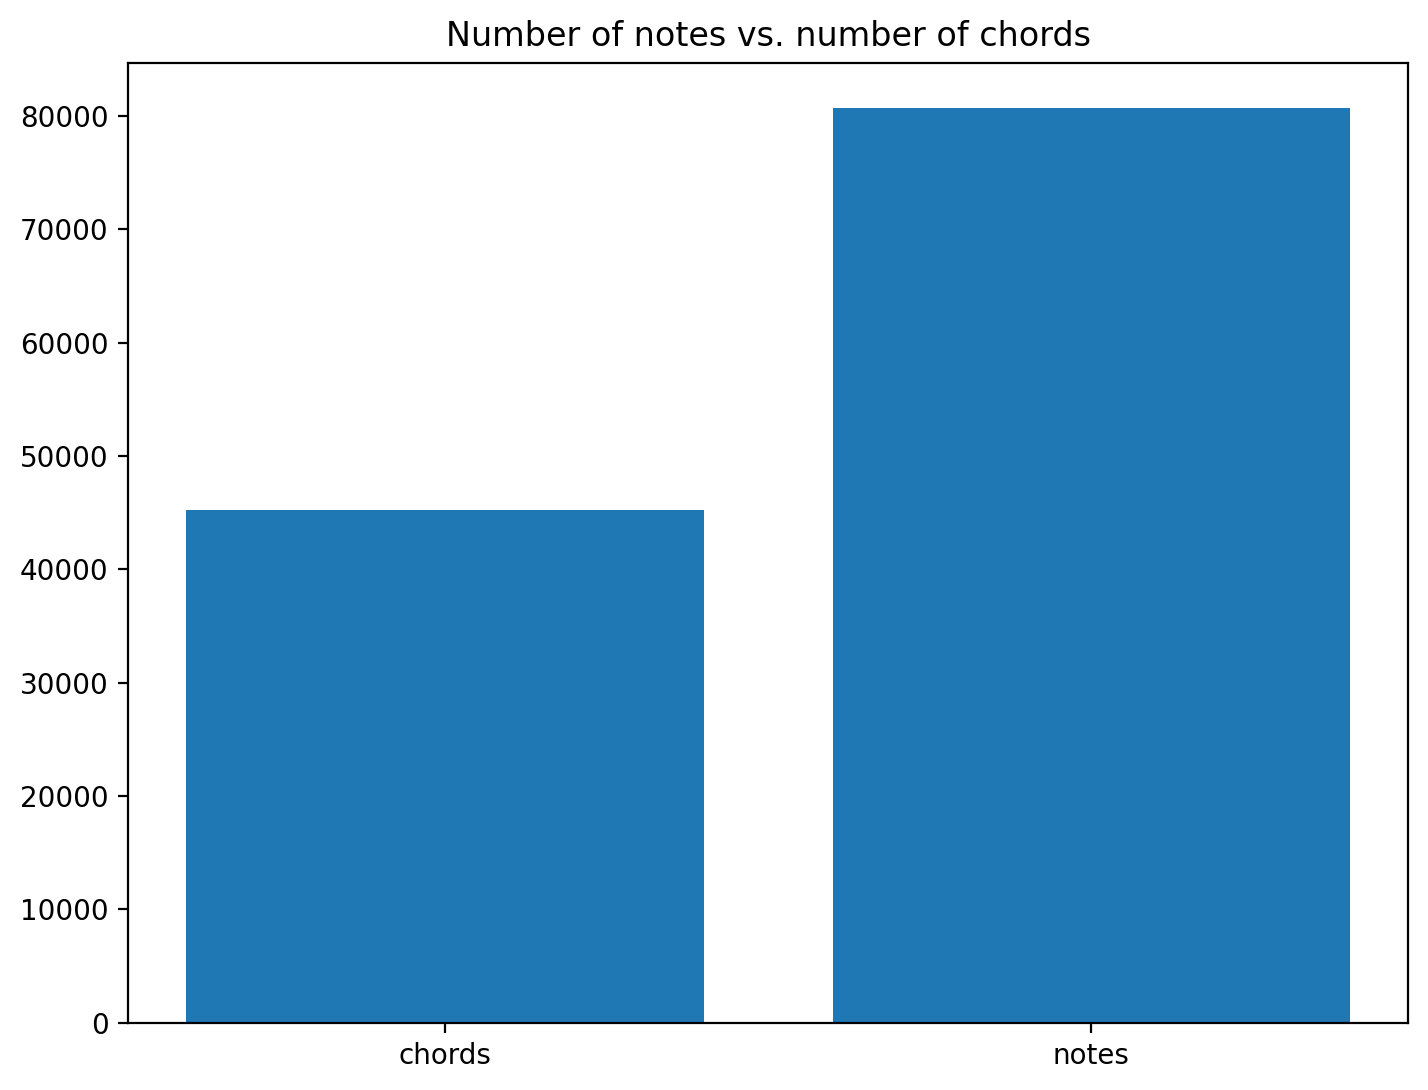

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['chords', 'notes']
ax.bar(labels, [total_chords, total_notes])
plt.title('Number of notes vs. number of chords')
plt.show()

In [ ]:
for i, s in enumerate(songs):
    if len(s) < block_size * 2:
        del songs[i]

In [22]:
song_lengths = []
for song in songs:
    song_lengths.append(len(song))

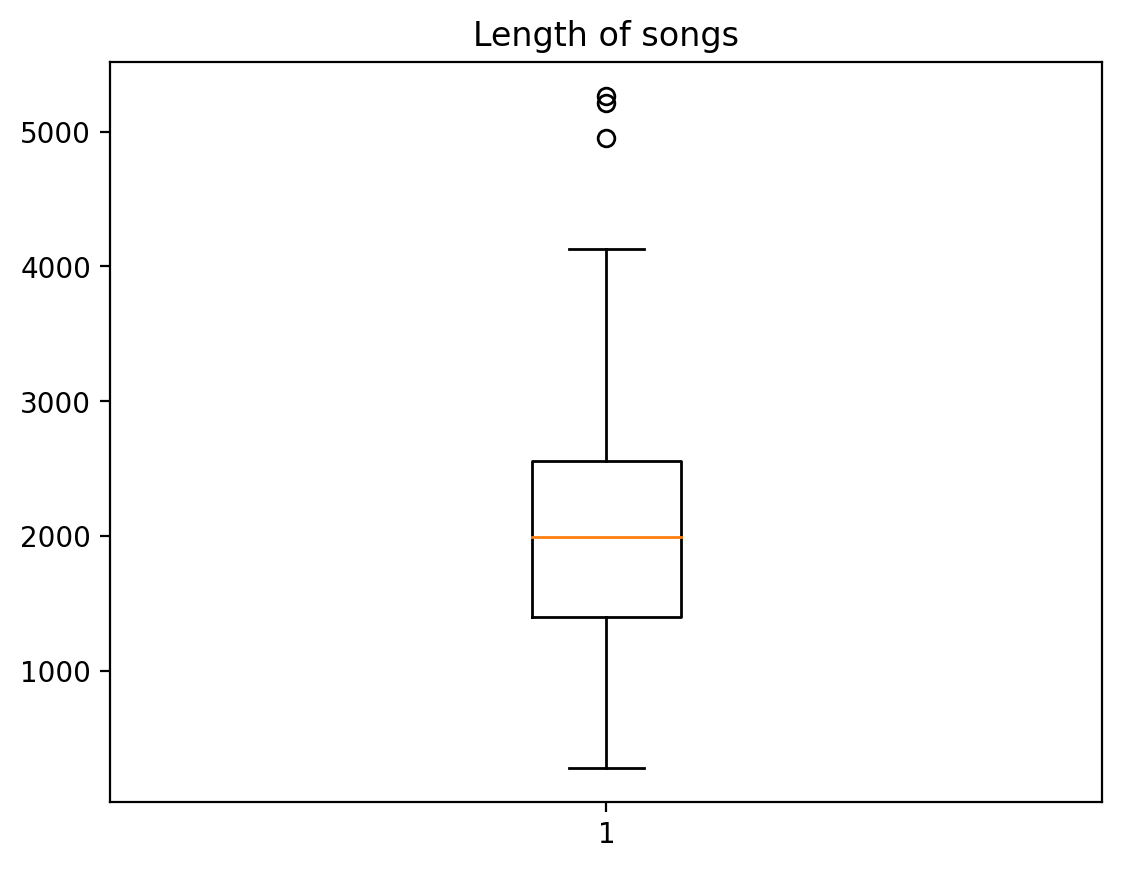

In [23]:
plt.boxplot(song_lengths)
plt.title('Length of songs')
plt.show()

In [25]:
note_counts = {}
for song in songs:
    for unit in song:
        if ("." in unit or unit.isdigit()):
            continue
        else:
            if unit not in note_counts.keys():
                note_counts[unit] = 1
            else:
                note_counts[unit] += 1

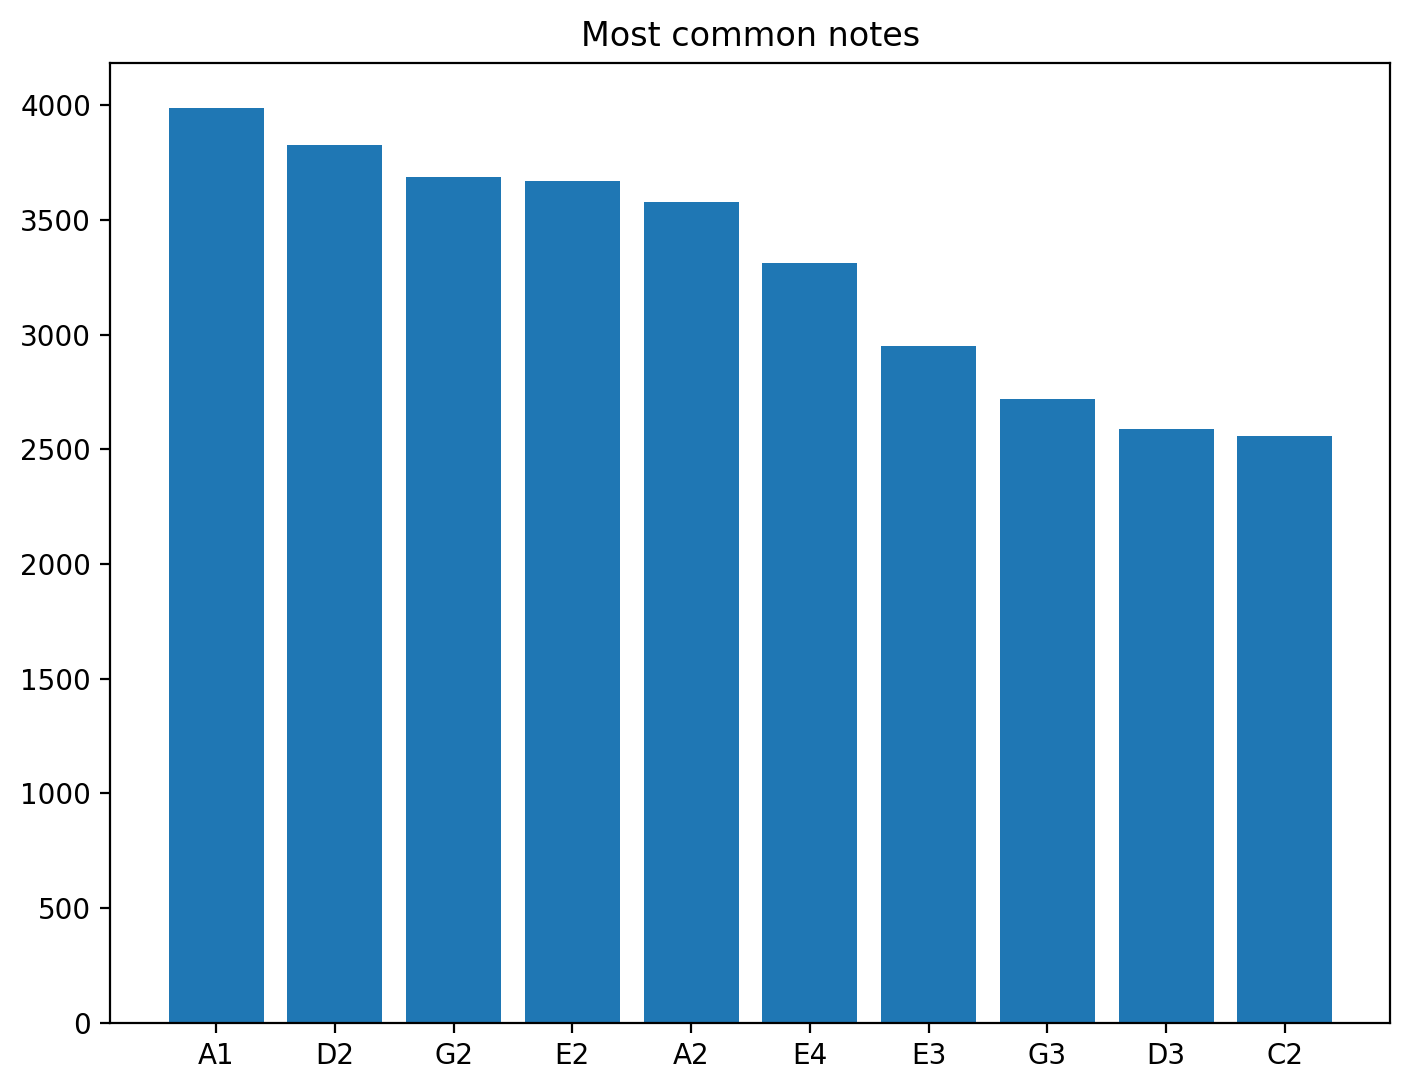

In [32]:
sorted_notes = list(reversed(sorted(note_counts.items(), key=lambda x:x[1])))[:10]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
notes = []
values = []
for note in sorted_notes:
    notes.append(note[0])
    values.append(note[1])
ax.bar(notes, values)
plt.title('Most common notes')
plt.show()

## Data prep

Here I will prepare the data to be fed into the deep learning model. All that is happening here is I am creating a vocab for all the different notes and chords used in all the songs. After that I have functions for converting the notes/chords into their integer tokens which will be their index into the embedding matrix.

In [5]:
vocab = set()
for song in songs:
    for note in song:
        vocab.add(note)

In [6]:
vocab_size = len(vocab)
vocab_size

336

In [7]:
note_to_idx = {ch:i for i, ch in enumerate(vocab)}
idx_to_note = {i:ch for i, ch in enumerate(vocab)}

In [8]:
encode = lambda s: [note_to_idx[c] for c in s]
decode = lambda l: ' '.join([idx_to_note[i] for i in l])

In [9]:
for i in range(len(songs)):
    songs[i] = encode(songs[i])

In [10]:
test_data_x = []
test_data_y = []
for song in songs:
    test_data_x.append(song[len(song)-block_size-1:len(song)-1])
    test_data_y.append(song[len(song)-block_size:])

This method will grab a batch by picking a random song and then randomly picking a chunks of that song.

In [27]:
import random

batch_size = 64

def get_batch():
    s = songs[random.randint(0, len(songs)-1)]
    ix = []
    for _ in range(batch_size):
        if len(s) < block_size*2:
            print(s)
        ix.append(random.randint(0, len(s)-(block_size*2)))
    #ix = torch.randint(len(s) - block_size*2, (batch_size,))
    x = torch.tensor([s[i: i+block_size] for i in ix])
    y = torch.tensor([s[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

## Deep Learning with Attention based model

Here I create an Attention model. This model will look at notes/chords and try to guess the note/chord that would come after that. The Architechure for this model can be found in [this](https://arxiv.org/abs/1706.03762) research paper.

In [ ]:
block_size = 256
max_iter = 5000
eval_interval = 500
lr = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

In [12]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   #B, T, C
        q = self.query(x) #B, T, C
        wei = q @ k.transpose(-2, -1) * C**-0.5 #(B, T, C) * (B, C, t) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) #(B, T, T)
        wei = F.softmax(wei, dim=-1) #(B,T, T)
        wei = self.dropout(wei)
        v = self.value(x) #(B, T, C)
        out = wei @ v #(B, T, T) * (B, T, C) -> (B, T, C)
        return out

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [14]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd*4),
            nn.ReLU(),
            nn.Linear(n_embd*4, n_embd),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

In [15]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [16]:
class AttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx) #(B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) #(T, C)
        x = tok_emb + pos_emb #(B, T, C)
        x = self.blocks(x) #(B, T, C)
        x = self.ln_f(x) #(B, T, C)
        logits = self.lm_head(x) #(B, T, vocab_size)
        
        if targets is None:
            return logits, None
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(-1)
        loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [17]:
model = AttentionModel().to(device)

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [34]:
for step in range(max_iter):
    xb, yb = get_batch()
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if step % eval_interval == 0:
        print(f"Step {step}: Train loss {loss:.4f}")

Step 0: Train loss 4.4248
Step 500: Train loss 2.8359
Step 1000: Train loss 1.4210
Step 1500: Train loss 2.2513
Step 2000: Train loss 2.3418
Step 2500: Train loss 1.2381
Step 3000: Train loss 1.5597
Step 3500: Train loss 1.2254
Step 4000: Train loss 1.4271
Step 4500: Train loss 1.1596


In [41]:
import music21
from midi2audio import FluidSynth

def notes_to_midi(snippet):
    melody = []
    offset = 0 
    for i in snippet.split():
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = music21.note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = music21.chord.Chord(notes)
                chord_snip.offset = offset
                melody.append(chord_snip)
        else: 
            note_snip = music21.note.Note(i)
            note_snip.offset = offset
            melody.append(note_snip)
        offset += 1
    melody_midi = music21.stream.Stream(melody)   
    return melody_midi

In [ ]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
gen_song = notes_to_midi(decode(model.generate(context, max_new_tokens=300)[0].tolist()))

In [42]:
gen_song.write('midi',f'midi_tst_{0}.mid')

'midi_tst_0.mid'